In [22]:
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

tf.config.allow_growth = True
tf.config.per_process_gpu_memory_fraction = 0.9

from random import randint
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
import random as rdn

In [23]:
# check the tensorflow version
print('Tensorflow Version: ' + tf.__version__)

# check the number of available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.8.0
Num GPUs: 0


<AxesSubplot:xlabel='count', ylabel='category'>

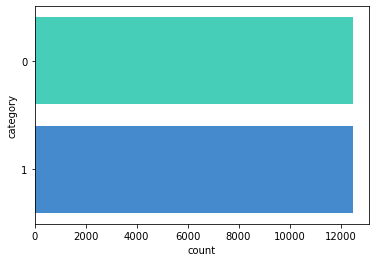

In [24]:
# set the directory for train and validation images
train_path = r'C:\Users\chaud\OneDrive\Desktop\Python\Deep Learning\CNN_ dog &cat kaggle/train/'

# function to create a list of image labels 
def createImageDf(path):
    filenames = os.listdir(path)
    categories = []

    for fname in filenames:
        category = fname.split('.')[0]
        if category == 'dog':
            categories.append(1)
        else:
            categories.append(0)
    df = pd.DataFrame({
        'filename':filenames,
        'category':categories
    })
    return df

# display the header of the train_df dataset
image_df = createImageDf(train_path)
image_df.head(5)

sns.countplot(y='category', data=image_df, palette=['#2FE5C7',"#2F8AE5"], orient="h")

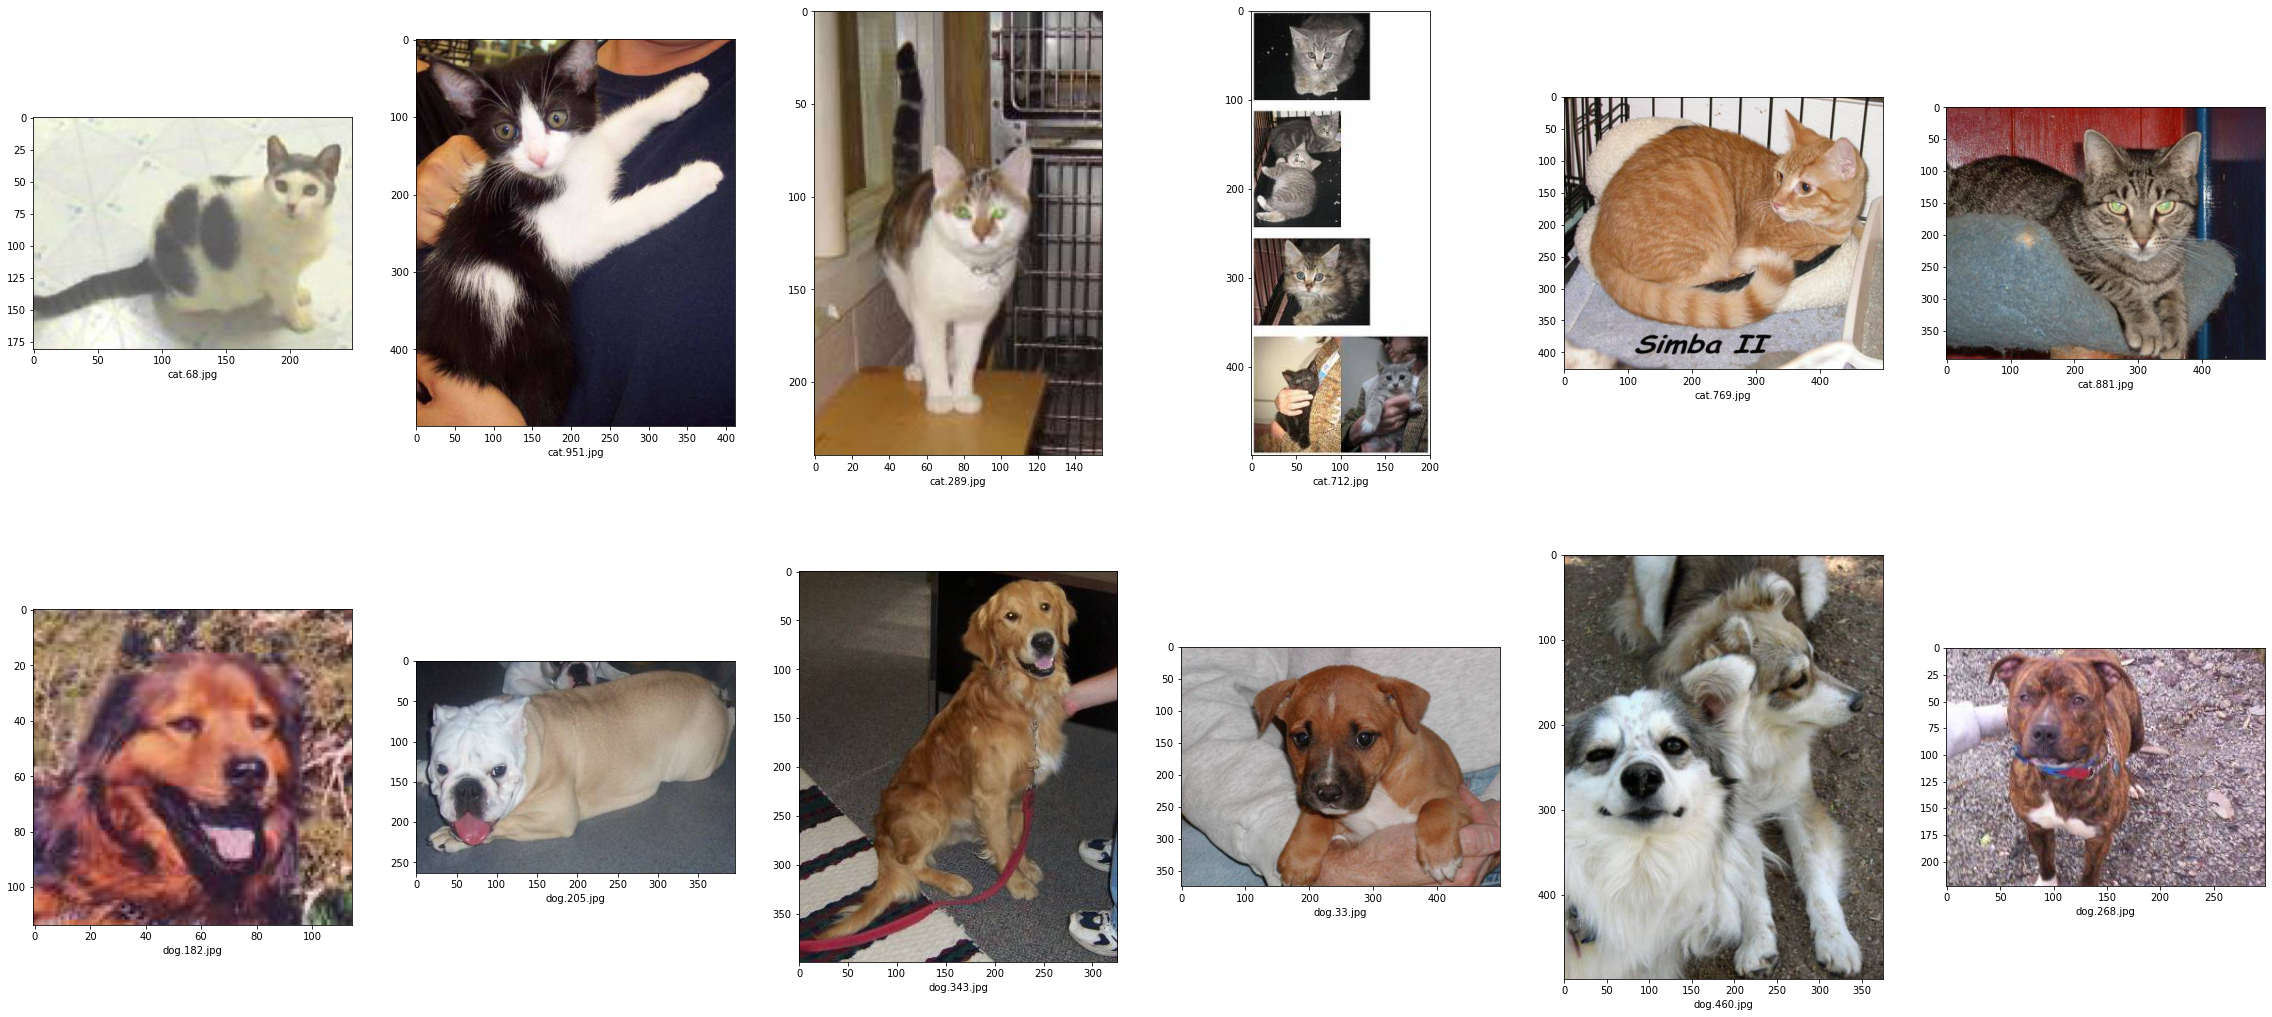

In [25]:
n_pictures = 12 # number of pictures to be shown
columns = int(n_pictures / 2)
rows = 2
plt.figure(figsize=(40, 18))
for i in range(n_pictures):
    num = i + 1
    ax = plt.subplot(rows, columns, i + 1)
    if i < columns:
        image_name = 'cat.' + str(rdn.randint(1, 1000)) + '.jpg'
    else: 
        image_name = 'dog.' + str(rdn.randint(1, 1000)) + '.jpg'
    plt.xlabel(image_name)    
    plt.imshow(load_img(train_path + image_name)) 


In [26]:
image_df["category"] = image_df["category"].replace({0:'cat',1:'dog'})

train_df, validate_df = train_test_split(image_df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
total_train = train_df.shape[0]

validate_df = validate_df.reset_index(drop=True)
total_validate = validate_df.shape[0]
train_df.head()

print(len(train_df), len(validate_df))

20001 5001


In [27]:
# set the dimensions to which we will convert the images
img_width, img_height = 128, 128
target_size = (img_width, img_height)
batch_size = 64
rescale=1.0/255

# configure the train data generator
print('Train data:')
train_datagen = ImageDataGenerator(rescale=rescale)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_path,
    shear_range=0.2, #
    zoom_range=0.2, #
    horizontal_flip=True, # 
    shuffle=True, # shuffle the image data
    x_col='filename', y_col='category',
    classes=['dog', 'cat'],
    target_size=target_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='binary')


# configure test data generator
# only rescaling
print('Test data:')
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_path,    
    shuffle=True,
    x_col='filename', y_col='category',
    classes=['dog', 'cat'],
    target_size=target_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='binary')

Train data:
Found 20001 validated image filenames belonging to 2 classes.
Test data:
Found 5001 validated image filenames belonging to 2 classes.


In [28]:
# define the input format of the model
input_shape = (img_width, img_height, 3)
print(input_shape)

# define  model
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(128, (3, 3),  strides=(1, 1),activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

(128, 128, 3)


In [29]:
# compile the model and print its architecture
opt = SGD(learning_rate=0.001, momentum=0.9)
history = model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0

In [ ]:
# train the model
epochs = 20
early_stop = EarlyStopping(monitor='loss', patience=6, verbose=1)

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[early_stop],
    steps_per_epoch=len(train_generator),
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/20
 48/313 [===>..........................] - ETA: 15:19 - loss: 0.8707 - accuracy: 0.4938

In [ ]:
# Save the weights
model.save_weights('cats-and-dogs-weights-v1.h5')

# Define model as during training
# model architecture

# Loads the weights
model.load_weights('cats-and-dogs-weights-v1.h5')  

In [ ]:
model.save("cat_dog_classifier_kaggle.h5")

In [ ]:
def plot_loss(history, value1, value2, title):
    fig, ax = plt.subplots(figsize=(15, 5), sharex=True)
    plt.plot(history.history[value1], 'b')
    plt.plot(history.history[value2], 'r')
    plt.title(title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.grid()
    plt.show()

# plot training & validation loss values
plot_loss(history, "loss", "val_loss", "Model loss")
# plot training & validation loss values
plot_loss(history, "accuracy", "val_accuracy", "Model accuracy")

In [ ]:
# function that returns the label for a given probability
def getLabel(prob):
    if(prob > .5):
               return 'dog'
    else:
               return 'cat'

# get the predictions for the validation data
val_df = validate_df.copy()
val_df['pred'] = ""
val_pred_prob = model.predict(validation_generator)

for i in range(val_pred_prob.shape[0]):
    val_df['pred'][i] = getLabel(val_pred_prob[i])
          
# create a confusion matrix
y_val = val_df['category']
y_pred = val_df['pred']

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))
cnf_matrix = confusion_matrix(y_val, y_pred)

# plot the confusion matrix in form of a heatmap

%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(8, 8))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
# set the path to the sample images
sample_path =  r'C:\Users\chaud\OneDrive\Desktop\Python\Deep Learning\CNN_ dog &cat kaggle/Sample_Images/'
sample_df = createImageDf(sample_path)
sample_df['category'] = sample_df['category'].replace({0:'cat',1:'dog'})
sample_df['pred'] = ""

# create an image data generator for the sample images - we will only rescale the images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    sample_df, 
    sample_path,    
    shuffle=False,
    x_col='filename', y_col='category',
    target_size=target_size)

# make the predictions 
pred_prob = model.predict(test_generator)
image_number = pred_prob.shape[0]

# define the plot size
for i in range(pred_prob.shape[0]):
    sample_df['pred'][i] = getLabel(pred_prob[i])
    
print('Accuracy: {:.2f}'.format(accuracy_score(sample_df['category'], sample_df['pred'])))

nrows = 4
ncols = int(round(image_number / nrows, 0))
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20))
for i, ax in enumerate(fig.axes):
    if i < sample_df.shape[0]:
        filepath = sample_path + sample_df.at[i ,'filename']
        ax = ax
        img = Image.open(filepath).resize(target_size)
        ax.imshow(img)
        ax.set_title(sample_df.at[i ,'filename'] + '\n' + ' predicted: '  + str(sample_df.at[i ,'pred']))
        result = [True if sample_df.at[i ,'pred'] == sample_df.at[i ,'category'] else False]
        ax.set_xlabel(str(result))
        ax.set_xticks([]); ax.set_yticks([]) 

In [ ]:
filenames = os.listdir("test1")

test_data = pd.DataFrame({
    'filename': filenames
})


In [ ]:

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_dataframe(
        test_data,
        r'C:\Users\chaud\OneDrive\Desktop\Python\Deep Learning\CNN_ dog &cat kaggle/test1/'
        ,
        x_col='filename',
        y_col=None,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode="rgb",
        shuffle=False
        )          

In [ ]:
# get the predictions for the validation data
test_df = test_data.copy()
test_df['pred'] = ""
test_df_prob = model.predict(test_generator)

for i in range(test_df_prob.shape[0]):
    test_df['pred'][i] = getLabel(test_df_prob[i])

In [ ]:
submission_df = test_df.copy()
submission_df = submission_df.reset_index(drop=True)
# submission_df.to_csv('submission.csv', index=False)

### Live Data Prediction On Image

In [1]:
import os 
os.getcwd()

'C:\\Users\\chaud\\OneDrive\\Desktop\\Python\\Deep Learning\\CNN_ dog &cat kaggle'

In [2]:
from keras import models

In [3]:
model = models.load_model("cat_dog_classifier_kaggle.h5")

In [4]:
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import cv2

In [6]:
#to predict new images 
def predict_image(imagepath):
    predict = image.load_img(imagepath, target_size = (128, 128),color_mode="rgb")   
    predict_modified = image.img_to_array(predict)
    predict_modified = predict_modified / 255
    predict_modified = np.expand_dims(predict_modified, axis = 0)
    result = model.predict(predict_modified)
    plt.imshow(cv2.imread(imagepath))
    if result[0][0] >= 0.5:
        prediction = 'dog'
        probability = result[0][0]
        print ("probability = " + str(probability))
        print("Prediction = " + prediction)
    else:
        prediction = 'cat'
        probability = 1 - result[0][0]
        print ("probability = " + str(probability))
        print("Prediction = " + prediction)
        plt.imshow(cv2.imread(imagepath))

probability = 0.8473232090473175
Prediction = cat


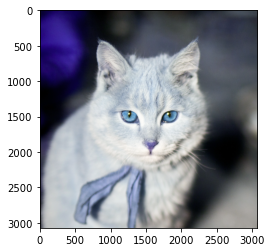

In [7]:
predict_image("demo1.jpg")

probability = 0.58306396
Prediction = dog


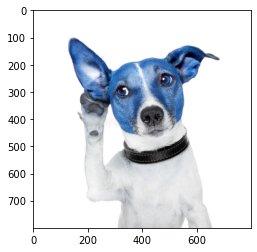

In [8]:
predict_image("demo2.jpg")

probability = 0.7040115
Prediction = dog


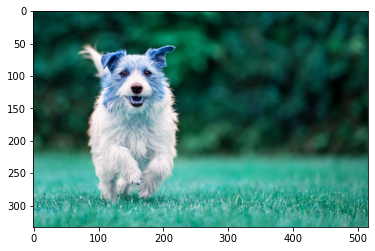

In [9]:
predict_image("demo3.jpg")

probability = 0.8121638596057892
Prediction = cat


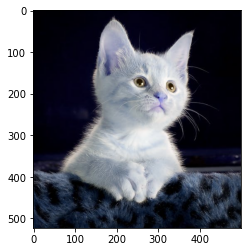

In [10]:
predict_image("demo4.jpeg")

probability = 0.8521189
Prediction = dog


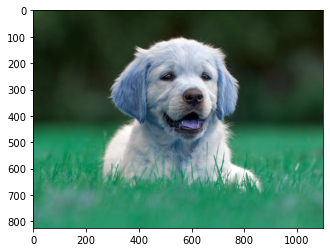

In [11]:
predict_image("a.jpg")